In [1]:
import os
import pandas

import numpy as np
import itertools

from multiprocessing import Pool

import scipy as sp
from scipy import optimize

import pickle as pkl

def exgauss_pdf(x, mu, sigma, nu):

    nu = 1./nu

    p1 = nu / 2. * np.exp((nu/2.)  * (2 * mu + nu * sigma**2. - 2. * x))


    p2 = sp.special.erfc((mu + nu * sigma**2 - x)/ (np.sqrt(2.) * sigma))

    return p1 * p2

def mixed_exgauss_likelihood(x, w, mu, sigma, nu):

    # Create indiviudal
    pdfs = w * exgauss_pdf(x[:, np.newaxis], mu, nu, sigma)

    ll = np.sum(np.log(np.sum(pdfs, 1)))

    if ((np.isnan(ll)) | (ll == np.inf)):
        return -np.inf


    return ll

def input_optimizer(pars, x, n_clusters):

    pars = np.array(pars)

    if np.sum(pars[:n_clusters-1]) > 1:
        return np.inf

    pars = np.insert(pars, n_clusters-1, 1 - np.sum(pars[:n_clusters-1]))

    if np.any(pars[:n_clusters] < 0.05):
        return np.inf

    w = pars[:n_clusters][np.newaxis, :]
    mu = pars[n_clusters:n_clusters*2][np.newaxis, :]
    nu = pars[n_clusters*2:n_clusters*3][np.newaxis, :]
    sigma = pars[n_clusters*3:n_clusters*4][np.newaxis, :]

    return -mixed_exgauss_likelihood(x, w, mu, sigma, nu)


def _fit(input_args, disp=False, popsize=100, **kwargs):

    sp.random.seed()

    x, n_clusters = input_args

    weight_bounds = [(1e-3, 1)] * (n_clusters - 1)
    mu_bounds = [(-1., 2.5)] * n_clusters
    nu_bounds = [(1e-3, 2.5)] * n_clusters
    sigma_bounds = [(1e-3, 2.5)] * n_clusters

    bounds = weight_bounds + mu_bounds + nu_bounds + sigma_bounds

    result = sp.optimize.differential_evolution(input_optimizer, bounds, (x, n_clusters), polish=True, disp=disp, maxiter=500, popsize=popsize, **kwargs)
    result = sp.optimize.minimize(input_optimizer, result.x, (x, n_clusters), method='SLSQP', bounds=bounds, **kwargs)

    return result

class SimpleExgaussMixture(object):


    def __init__(self, data, n_clusters):

        self.data = data
        self.n_clusters = n_clusters
        self.n_parameters = n_clusters * 4 - 1
        self.likelihood = -np.inf

        self.previous_likelihoods = []
        self.previous_pars = []


    def get_likelihood_data(self, data):
        
        return mixed_exgauss_likelihood(data, self.w, self.mu, self.sigma, self.nu)
    
    def get_bic_data(self, data):
        likelihood = self.get_likelihood_data(data)
        return - 2 * likelihood + self.n_parameters * np.log(data.shape[0])
        
        
    def get_aic_data(self, data):
        likelihood = self.get_likelihood_data(data)
        return 2 * self.n_parameters - 2  * likelihood
    

    def _fit(self, **kwargs):
        return _fit((self.data, self.n_clusters), **kwargs)



    def fit(self, n_tries=1, **kwargs):
        for run in np.arange(n_tries):

            result = self._fit(**kwargs)
            self.previous_likelihoods.append(-result.fun)

            if -result.fun > self.likelihood:

                pars = result.x
                pars = np.insert(pars, self.n_clusters-1, 1 - np.sum(pars[:self.n_clusters-1]))

                self.w = pars[:self.n_clusters][np.newaxis, :]
                self.mu = pars[self.n_clusters:self.n_clusters*2][np.newaxis, :]
                self.nu = pars[self.n_clusters*2:self.n_clusters*3][np.newaxis, :]
                self.sigma = pars[self.n_clusters*3:self.n_clusters*4][np.newaxis, :]

                self.likelihood = -result.fun

        self.aic = 2 * self.n_parameters - 2 * self.likelihood
        self.bic = - 2 * self.likelihood + self.n_parameters * np.log(self.data.shape[0])



    def fit_multiproc(self, n_tries=4, n_proc=4, disp=False):

        pool = Pool(n_proc)

        print 'starting pool'
        results = pool.map(_fit, [(self.data, self.n_clusters)] * n_tries)
        print 'ready'

        print results



        pool.close()

        for result in results:
            self.previous_likelihoods.append(-result.fun)
            self.previous_pars.append(result.x)

            if -result.fun > self.likelihood:

                pars = result.x
                pars = np.insert(pars, self.n_clusters-1, 1 - np.sum(pars[:self.n_clusters-1]))

                self.w = pars[:self.n_clusters][np.newaxis, :]
                self.mu = pars[self.n_clusters:self.n_clusters*2][np.newaxis, :]
                self.nu = pars[self.n_clusters*2:self.n_clusters*3][np.newaxis, :]
                self.sigma = pars[self.n_clusters*3:self.n_clusters*4][np.newaxis, :]

                self.likelihood = -result.fun

        self.aic = 2 * self.n_parameters - 2 * self.likelihood
        self.bic = - 2 * self.likelihood + self.n_parameters * np.log(self.data.shape[0])

    def plot_fit(self):
        # Create indiviudal pds

        t = np.linspace(0, self.data.max(), 100)
        pdfs = self.w * exgauss_pdf(t[:, np.newaxis], self.mu, self.nu, self.sigma)

        sns.distplot(self.data)
        plt.plot(t, pdfs, c='k', alpha=0.5)

        plt.plot(t, np.sum(pdfs, 1), c='k', lw=2)

In [2]:
import pickle as pkl
subject_ids = [14037, 15033, 15035, 14069, 13095, 14051, 15055]
stains = [u'CALR', u'FER', u'GABRA3', u'GAD6567', u'MBP', u'PARV', u'SERT', u'SMI32', u'SYN', u'TH', u'TRANSF', u'VGLUT1']
n_clusters = [1,2,3, 4, 5, 6]

In [3]:
import glob
import re

# BIC/AIC

In [4]:
fns = glob.glob('/home/gdholla1/data/post_mortem/ml_clusters_gradient/*.pkl')
reg = re.compile('.*/(?P<subject_id>[0-9]+)_(?P<fwhm>[0-9]+\.[0-9]+)_(?P<stain>.*)_(?P<n_clusters>[0-9]+)\.pkl')

import pandas
fns = [fn for fn in fns if reg.match(fn)]
df = pandas.DataFrame([reg.match(fn).groupdict() for fn in fns])
df['fn'] = fns
df['fwhm'] = df['fwhm'].astype(float)
# df['bic'] = df.fn.apply(lambda fn: pkl.load(open(fn)).bic)
# df['aic'] = df.fn.apply(lambda fn: pkl.load(open(fn)).aic)
df['fit_object'] = df.fn.apply(lambda fn: pkl.load(open(fn)))

df['bic'] = df.fit_object.apply(lambda x: x.bic)
df['aic'] = df.fit_object.apply(lambda x: x.bic)

In [5]:
tmp = df[df.subject_id != '12104'].pivot_table(index=['subject_id','stain'], columns=['fwhm', 'n_clusters'])
tmp['bic_best_model'] = np.nanargmin(tmp['bic', 0.3].values, 1) + 1
tmp['aic_best_model'] = np.nanargmin(tmp['aic', 0.3].values, 1) + 1
tmp = tmp.reset_index()

In [6]:
tmp_bic = tmp

# Within-specimen cross validation

In [7]:
df = pandas.concat([pandas.read_pickle(fn) for fn in glob.glob('/home/gdholla1/data/post_mortem/ml_clusters_gradient_cross_validated/*_all.pandas')])

In [8]:
# df.pivot_table(index='subject_id', columns=['test', 'train', 'stain', 'n_clusters'], values='ll')
df['ll_norm'] = df.groupby(['stain', 'subject_id']).ll.transform(lambda x: x / x.mean())
df = df[df.subject_id != 12104]

In [9]:
df['out_of_sample'] = df.test != df.train


In [10]:
df['ll_norm'] = df.groupby(['stain', 'subject_id', 'fwhm']).ll.transform(lambda x: x / x.mean())

In [11]:
tmp = df.pivot_table(index=['out_of_sample', 'subject_id','stain'], columns=['fwhm', 'n_clusters'])
tmp['number of clusters'] = np.nanargmax(tmp['ll_norm', 0.3].values, 1) + 1
tmp = tmp.reset_index()
tmp = tmp[tmp.out_of_sample]

In [12]:
tmp_cv_within = tmp

In [13]:
tmp_bic = tmp_bic[['subject_id', 'stain', 'bic_best_model']]
tmp_bic.columns = tmp_bic.columns.get_level_values(0)
tmp_bic['subject_id'] = tmp_bic['subject_id'].astype(int)
tmp_bic['BIC/AIC'] = tmp_bic['bic_best_model']


tmp_cv_within = tmp_cv_within[['subject_id', 'stain', 'number of clusters']]
tmp_cv_within.columns = tmp_cv_within.columns.get_level_values(0)
tmp_cv_within['cross validation within-specimens'] = tmp_cv_within['number of clusters']

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
tmp_swarm = tmp_bic.merge(tmp_cv_within, on=['subject_id', 'stain'], how='outer')

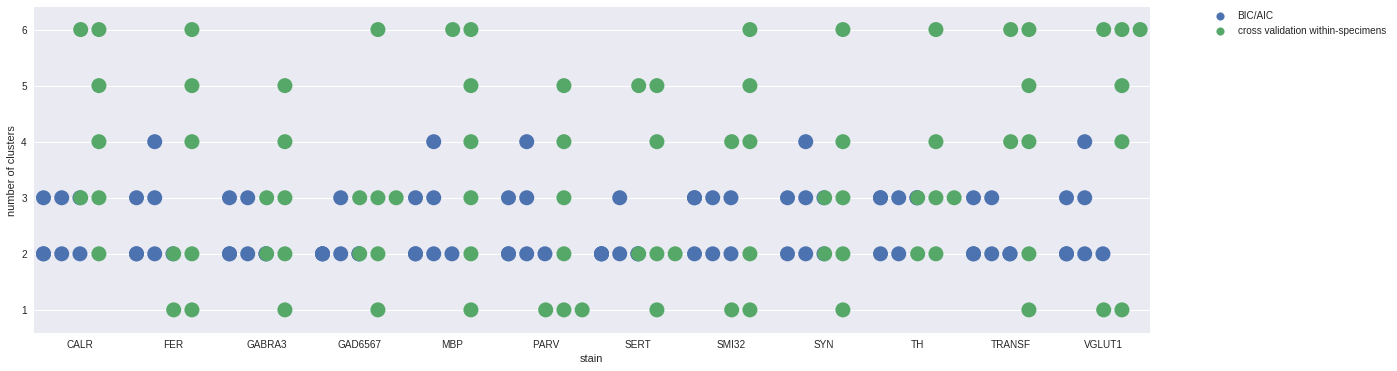

In [15]:
fac = sns.swarmplot('stain', 'number of clusters', 'variable', pandas.melt(tmp_swarm, id_vars=['subject_id', 'stain'], value_vars=['BIC/AIC', 'cross validation within-specimens'], value_name='number of clusters'), split=True, size=15)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.gcf().set_size_inches(20, 6)

# Get across-specimen cross validation


In [16]:
subject_ids = [14037, 15033, 15035, 14069, 13095, 14051, 15055]

stains = [u'CALR', u'FER', u'GABRA3', u'GAD6567', u'MBP', u'PARV', u'SERT', u'SMI32', u'SYN', u'TH', u'TRANSF', u'VGLUT1']
n_clusters = [1,2,3, 4, 5, 6]

fwhm = 0.3

In [17]:
def rescale_distribution_to(target, other):    
    def minimize_ks(pars):
        a, b = pars
        return sp.stats.ks_2samp(target, a + b * other)[0]
    
    result = sp.optimize.minimize(minimize_ks, ((0., 1.)), method='Nelder-Mead')
    
    a, b = result.x
    
    return a + b * other
    
    
    

In [18]:
results = []

for subject_id in subject_ids:
    for stain in stains:
        for n_clusters in [1,2,3, 4, 5, 6]:
            for other_subject_id in subject_ids:
                print subject_id, stain, n_clusters, other_subject_id
                
                
                try:
                    model = pkl.load(open('/home/gdholla1/data/post_mortem/ml_clusters_gradient/{subject_id}_{fwhm}_{stain}_{n_clusters}.pkl'.format(**locals())))
                    other_model = pkl.load(open('/home/gdholla1/data/post_mortem/ml_clusters_gradient/{other_subject_id}_{fwhm}_{stain}_{n_clusters}.pkl'.format(**locals())))
                    s = rescale_distribution_to(model.data, other_model.data)

                    ll = model.get_likelihood_data(s)

                    results.append({'train':subject_id,
                                    'test':other_subject_id,
                                    'n_clusters':n_clusters,
                                    'stain':stain,
                                    'fwhm':fwhm,
                                    'll':ll})
                    
                except Exception as e:
                    print "Problem!", e

14037 CALR 1 14037
14037 CALR 1 15033
14037 CALR 1 15035
14037 CALR 1 14069
14037 CALR 1 13095
14037 CALR 1 14051
14037 CALR 1 15055
14037 CALR 2 14037
14037 CALR 2 15033
14037 CALR 2 15035
14037 CALR 2 14069
14037 CALR 2 13095
14037 CALR 2 14051
14037 CALR 2 15055
14037 CALR 3 14037
14037 CALR 3 15033
14037 CALR 3 15035
14037 CALR 3 14069
14037 CALR 3 13095
14037 CALR 3 14051
14037 CALR 3 15055
14037 CALR 4 14037
14037 CALR 4 15033
14037 CALR 4 15035
14037 CALR 4 14069
14037 CALR 4 13095
14037 CALR 4 14051
14037 CALR 4 15055
14037 CALR 5 14037
14037 CALR 5 15033
14037 CALR 5 15035
14037 CALR 5 14069
14037 CALR 5 13095
14037 CALR 5 14051
14037 CALR 5 15055
14037 CALR 6 14037
14037 CALR 6 15033
14037 CALR 6 15035
14037 CALR 6 14069
14037 CALR 6 13095
14037 CALR 6 14051
14037 CALR 6 15055
14037 FER 1 14037
14037 FER 1 15033
14037 FER 1 15035
14037 FER 1 14069
14037 FER 1 13095
14037 FER 1 14051
14037 FER 1 15055
14037 FER 2 14037
14037 FER 2 15033
14037 FER 2 15035
14037 FER 2 14069
1403

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in multiply


14069 MBP 3 15033
14069 MBP 3 15035
14069 MBP 3 14069
14069 MBP 3 13095
14069 MBP 3 14051
14069 MBP 3 15055
14069 MBP 4 14037
14069 MBP 4 15033
14069 MBP 4 15035
14069 MBP 4 14069
14069 MBP 4 13095
14069 MBP 4 14051
14069 MBP 4 15055
14069 MBP 5 14037
14069 MBP 5 15033
14069 MBP 5 15035
14069 MBP 5 14069
14069 MBP 5 13095
14069 MBP 5 14051
14069 MBP 5 15055
14069 MBP 6 14037
14069 MBP 6 15033
14069 MBP 6 15035
14069 MBP 6 14069
14069 MBP 6 13095
14069 MBP 6 14051
14069 MBP 6 15055
14069 PARV 1 14037
14069 PARV 1 15033
14069 PARV 1 15035
14069 PARV 1 14069
14069 PARV 1 13095
14069 PARV 1 14051
14069 PARV 1 15055
14069 PARV 2 14037
14069 PARV 2 15033
14069 PARV 2 15035
14069 PARV 2 14069
14069 PARV 2 13095
14069 PARV 2 14051
14069 PARV 2 15055
14069 PARV 3 14037
14069 PARV 3 15033
14069 PARV 3 15035
14069 PARV 3 14069
14069 PARV 3 13095
14069 PARV 3 14051
14069 PARV 3 15055
14069 PARV 4 14037
14069 PARV 4 15033
14069 PARV 4 15035
14069 PARV 4 14069
14069 PARV 4 13095
14069 PARV 4 14051
1

In [19]:
results = pandas.DataFrame(results) 
results = results[results.ll != -np.inf]
results = results[results.test != results.train]

In [20]:
results['ll_norm'] = results.groupby(['train', 'stain']).ll.transform(lambda d: (d - d.mean()) / d.std())

In [21]:
tmp = results.pivot_table(index=['train', 'stain'], columns='n_clusters', aggfunc='median')
tmp['best_model'] = np.argmax(tmp['ll_norm'].values, 1) + 1

In [22]:
tmp = tmp['best_model'].to_frame('number of clusters').reset_index()
tmp = tmp.groupby(['stain', 'number of clusters']).size().to_frame('cross-validated across-specimens')
cv_across = tmp.reset_index()

In [23]:
tmp = results.pivot_table(index=['train', 'stain'], columns='n_clusters', aggfunc='median')
tmp['cross-validation across specimens'] = np.argmax(tmp['ll_norm'].values, 1) + 1
tmp['subject_id'] = tmp.index.get_level_values(0)
tmp_cv_across = tmp.reset_index()[['subject_id', 'stain', 'cross-validation across specimens']]
tmp_cv_across.columns = tmp_cv_across.columns.get_level_values(0)

In [24]:
tmp_swarm = tmp_swarm.merge(tmp_cv_across, on=['subject_id', 'stain'])

In [25]:
sns.set_context('poster')
sns.set_style('whitegrid')

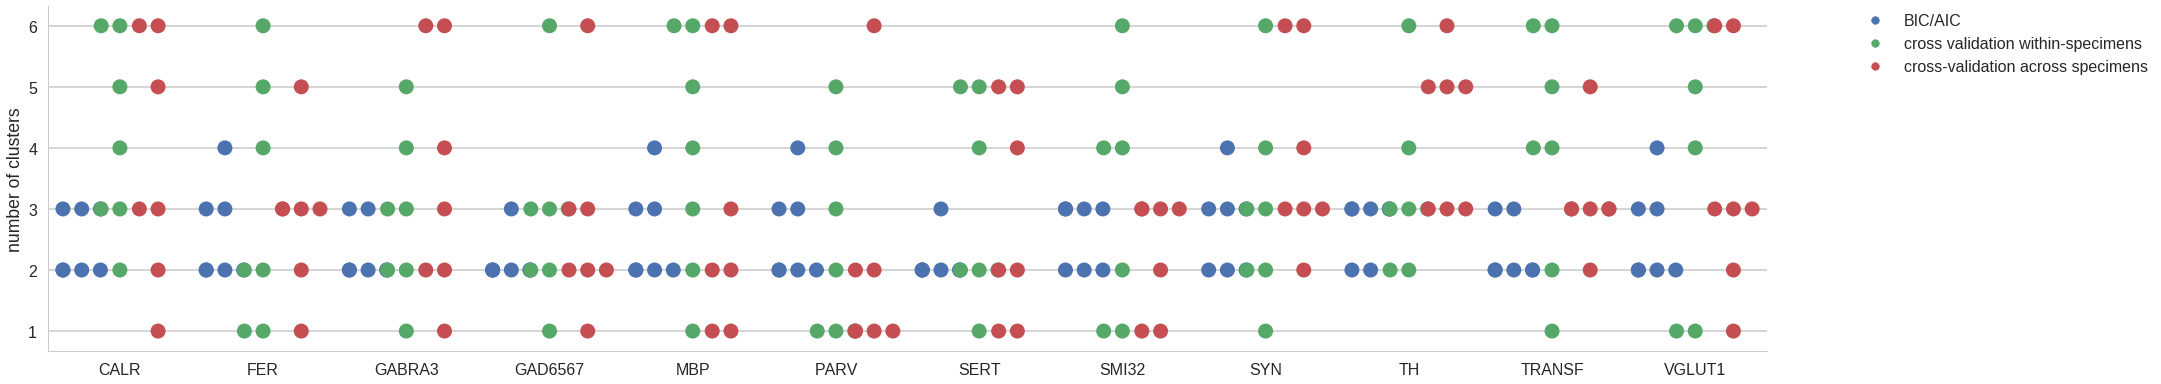

In [26]:
fac = sns.swarmplot('stain', 'number of clusters', 'variable', pandas.melt(tmp_swarm, id_vars=['subject_id', 'stain'], value_vars=['BIC/AIC', 'cross validation within-specimens', 'cross-validation across specimens'], value_name='number of clusters'), split=True, size=15)
sns.despine()
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.gcf().set_size_inches(25, 6)
plt.tight_layout()
fac.set_xlabel('')
plt.savefig('/home/gdholla1/projects/bias/reports/figures/model_comparisons_gradient.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [27]:
mapper = dict(zip(tmp_swarm.stain.unique().tolist(), np.arange(12)))
tmp_swarm['row'] = tmp_swarm.stain.map(lambda x: mapper[x] / 6)

In [28]:
sns.set_context('paper')

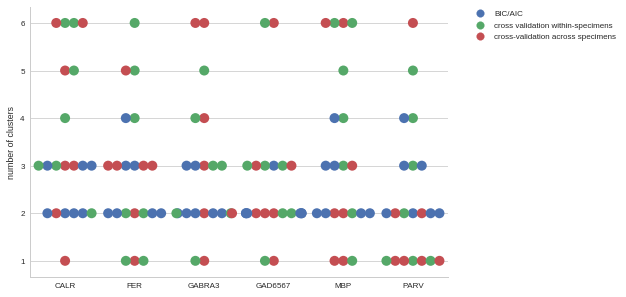

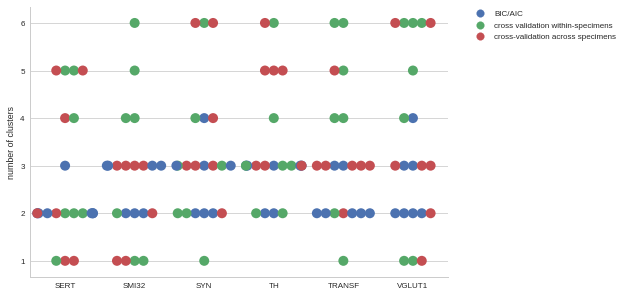

In [29]:
for row, t in pandas.melt(tmp_swarm, id_vars=['subject_id', 'stain', 'row'], value_vars=['BIC/AIC', 'cross validation within-specimens', 'cross-validation across specimens'], value_name='number of clusters').groupby('row'):
    plt.figure()
    fac = sns.swarmplot('stain', 'number of clusters', 'variable', t, s=10)
    sns.despine()
    lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # plt.gcf().set_size_inches(4.72440945, 1)
    plt.tight_layout()
    fac.set_xlabel('')
    plt.savefig('/home/gdholla1/projects/bias/reports/figures/model_comparisons_gradient_%d.pdf' % row,bbox_extra_artists=(lgd,), bbox_inches='tight')